# Install libraries

In [ ]:
!pip install llama-parse
!pip install graphlit-client
!pip install python-Levenshtein
!pip install matplotlib
!pip install pdf2image

# Load libraries

In [88]:
import os
import time
import nest_asyncio
nest_asyncio.apply()
from llama_parse import LlamaParse
from graphlit_client import Graphlit
from Levenshtein import ratio
from IPython.display import display, HTML
import base64
from pdf2image import convert_from_path
from io import BytesIO
from PIL import Image


# Set and download and a sample file

In [64]:
file_uri="https://www.princexml.com/samples/catalog/PrinceCatalogue.pdf"
file_path="./PrinceCatalogue.pdf"

In [44]:
# Configurations
UNSTRUCTED_API_URL="https://XXXXX.api.unstructuredapp.io/general/v0/general"
UNSTRUCTED_API_KEY="PxXXXX"
GRAPHLIT_ENV_ID="6XXXX"
GRAPHLIT_ORG_ID="fXXXX"
GRAPHLIT_SECRET_KEY="srXXXX"
LLAMA_PARSE_KEY="llx-XXXXX"

# Load with UnstructedAPI

In [45]:
import requests

url = UNSTRUCTED_API_URL

def unstructured_api_request(file_path):
  payload = {'strategy': 'hi_res', 'pdf_infer_table_structure': 'true'}
  files=[
    ('files',(file_path,open(file_path,'rb'),'application/pdf'))
  ]
  headers = {
    'accept': 'application/json',
    'unstructured-api-key': UNSTRUCTED_API_KEY
  }

  response = requests.request("POST", url, headers=headers, data=payload, files=files)
  unstructured_api_result = response.json()

  f = open(f"{file_path}_unstruct_result.txt", "a")
  for data in unstructured_api_result:
    f.write(f"{data['text']}\n")
  f.close()

unstructured_api_request(file_path)

# Load with Graphlit

In [57]:
def create_workflow():
    # Define the GraphQL mutation
    mutation = """
    mutation CreateWorkflow($workflow: WorkflowInput!) {
        createWorkflow(workflow: $workflow) {
            id
        }
    }
    """

    # Define the variables for the mutation
    variables = {
        "workflow": {
            "preparation": {
                "jobs": [
                    {
                    "connector": {
                        "type": "AZURE_DOCUMENT_INTELLIGENCE",
                        "azureDocument": {
                            "model": "LAYOUT"
                        }
                    }
                    }
                ]
            },
            "name": "Azure AI Document Intelligence"
        }
    }

    # Convert the request to JSON format
    response = client.request(query=mutation, variables=variables)

    if 'errors' in response and len(response['errors']) > 0:
        error_message = response['errors'][0]['message']
        return error_message

    return response['data']['createWorkflow']['id']

def delete_workflow(workflow_id):
    # Define the GraphQL mutation
    query = """
    mutation DeleteWorkflow($id: ID!) {
        deleteWorkflow(id: $id) {
            id
        }
        }
    """

    # Define the variables for the mutation
    variables = {
        "id": workflow_id
    }
    response = client.request(query=query, variables=variables)
    return response

def ingest_page(uri, workflow_id):
    # Define the GraphQL mutation
    mutation = """
    mutation IngestPage($uri: URL!, $workflow: EntityReferenceInput, $isSynchronous: Boolean) {
        ingestPage(uri: $uri, workflow: $workflow, isSynchronous: $isSynchronous) {
            id
            markdown
            document {
                title
                keywords
                author
                pageCount
            }
        }
    }
    """

    # Define the variables for the mutation
    variables = {
        "isSynchronous": True, # wait for content to be ingested
        "uri": uri,
        "workflow": {
            "id": workflow_id
        }
    }
    # Convert the request to JSON format
    response = client.request(query=mutation, variables=variables)
    print(response)
    if 'errors' in response and len(response['errors']) > 0:
        error_message = response['errors'][0]['message']
        return error_message

    content_data = response['data']['ingestPage']['markdown']

    return content_data


def ingest_file(uri, workflow_id):
    # Define the GraphQL mutation
    mutation = """
    mutation IngestFile($uri: URL!, $workflow: EntityReferenceInput, $isSynchronous: Boolean) {
        ingestFile(uri: $uri, workflow: $workflow, isSynchronous: $isSynchronous) {
            id
            markdown
            document {
                title
                keywords
                author
                pageCount
            }
        }
    }
    """

    # Define the variables for the mutation
    variables = {
        "isSynchronous": True, # wait for content to be ingested
        "uri": uri,
        "workflow": {
            "id": workflow_id
        }
    }
    # Convert the request to JSON format
    response = client.request(query=mutation, variables=variables)
    print(response)
    if 'errors' in response and len(response['errors']) > 0:
        error_message = response['errors'][0]['message']
        return error_message

    content_data = response['data']['ingestFile']['markdown']

    return content_data

client = Graphlit(environment_id=GRAPHLIT_ENV_ID,
                organization_id=GRAPHLIT_ORG_ID,
                secret_key=GRAPHLIT_SECRET_KEY)
graphlit_result_id = ingest_file(file_uri)
f = open(f"{file_path}_graphlit_result.txt", "w")
f.write(graphlit_result_id)
f.close()

# Load with LLama Parse

In [60]:
def llama_doc_parse(fileloc):
  parser = LlamaParse(
    api_key=LLAMA_PARSE_KEY,  # can also be set in your env as LLAMA_CLOUD_API_KEY
    result_type="text",  # "markdown" and "text" are available
    num_workers=4, # if multiple files passed, split in `num_workers` API calls
    verbose=True,
    language="en" # Optionaly you can define a language, default=en
  )
  # sync
  documents = parser.load_data(fileloc)
  return documents

llama_doc_parse_result = llama_doc_parse(file_path)
f = open(f"{file_path}_llama_result.txt", "w")
f.write(llama_doc_parse_result[0].text)
f.close()

# File Sample Compare

In [95]:
# Convert the first page image to a format that can be displayed in HTML
def img_to_base64(img):
    buffered = BytesIO()
    img.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/jpeg;base64,{img_str}"

# Function to read and return the content of a text file
def read_text_file(file_path):
    with open(file_path, 'r') as file:
        return file.read()
    
def compare_pdf_extraction(pdf_file, txt_file, title):
    # Step 1: Convert PDF to images
    # Make sure to replace 'path_to_your_pdf.pdf' with the actual path to your PDF file.
    pages = convert_from_path(pdf_file, 300)  # Adjust the DPI as needed

    # Step 2: Calculate the total height and the maximum width of all images combined
    total_height = sum(page.height for page in pages)
    max_width = max(page.width for page in pages)

    # Create a new, blank image that will contain all the pages
    combined_image = Image.new('RGB', (max_width, total_height))

    # Step 3: Paste each page into this blank image
    current_height = 0
    for page in pages:
        # Convert the PIL image to RGB (if not already in RGB, to avoid mode errors)
        rgb_page = page.convert('RGB')
        
        combined_image.paste(rgb_page, (0, current_height))
        current_height += rgb_page.height

        # Read the content of your text file
        text_content = read_text_file(txt_file)

    # Get the base64 string for the first page image
    img_base64 = img_to_base64(combined_image)

    # Create HTML layout for displaying the text and the image side by side
    html_content = f"""
    <h2>{title}</h2>
    <div style="display: flex; width: 100%; align-items: flex-start;">
        <div style="flex: 1; max-width: 50%;">
            <img src="{img_base64}" style="max-width: 100%; height: auto;">
        </div>      
        <div style="flex: 1; margin-right: 20px; max-width: 50%; overflow: auto; white-space: pre-wrap;">
            {text_content}
        </div>
    </div>
    """

    # Display the combined HTML
    display(HTML(html_content))


# Comparing Sample Catalouge
- https://www.princexml.com/samples/catalog/PrinceCatalogue.pdf


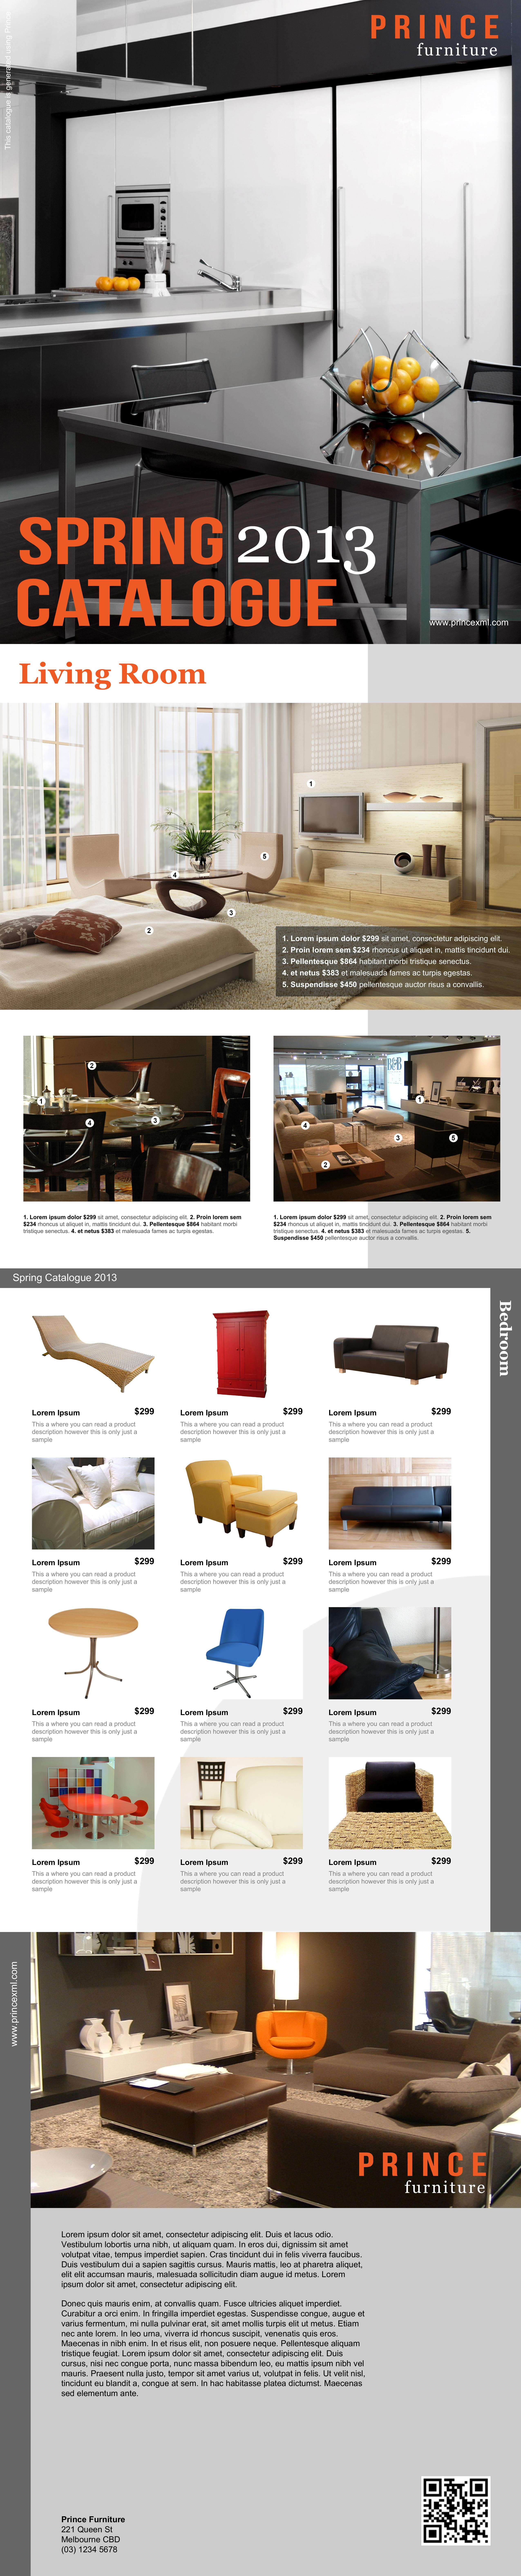


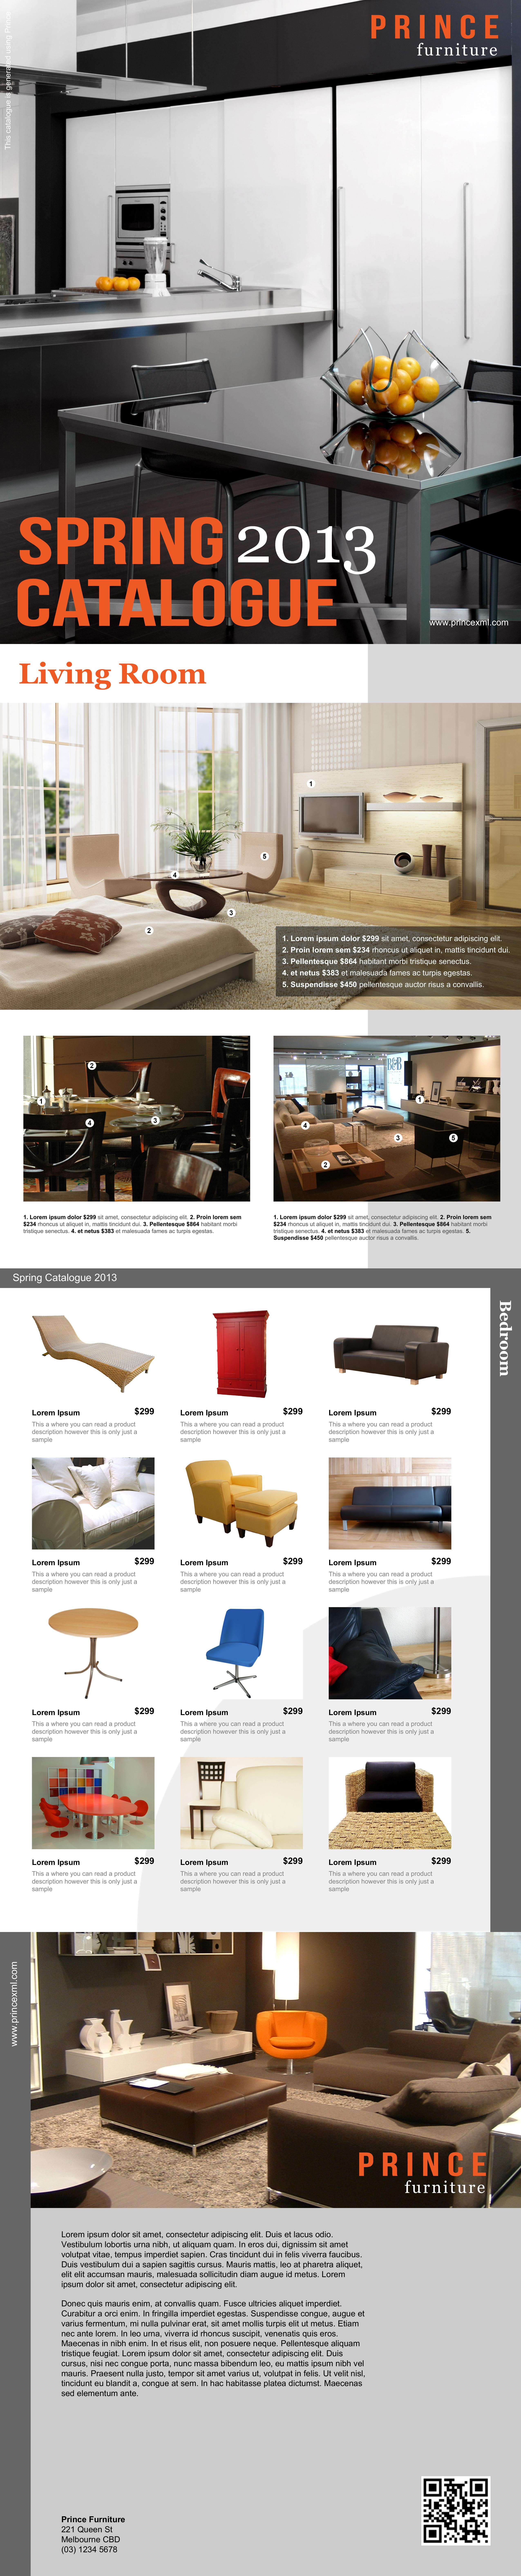


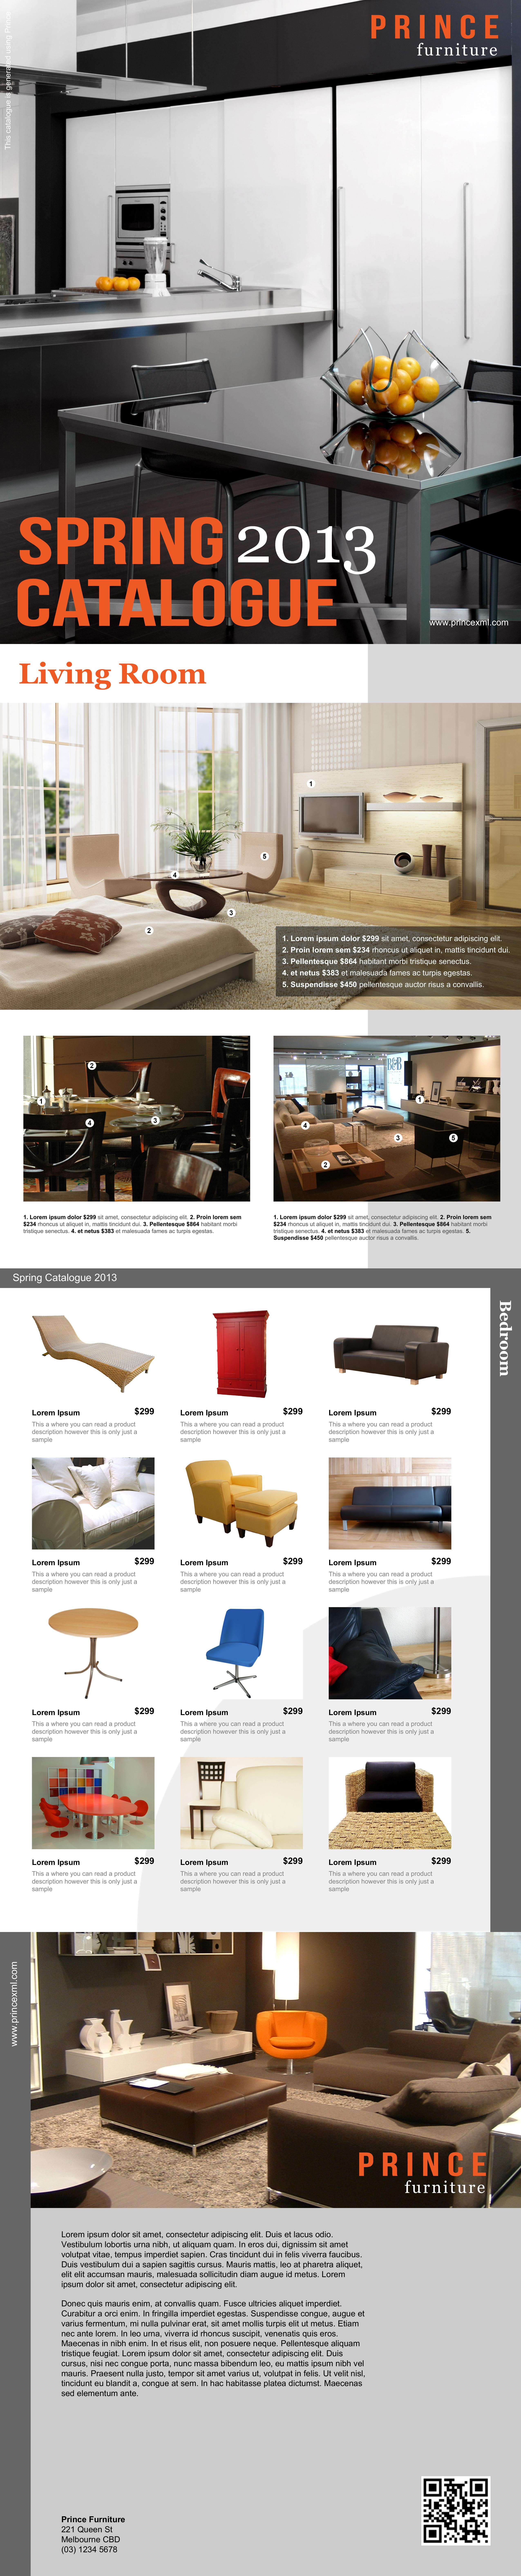

In [96]:
file=1
compare_pdf_extraction(f'./Data/{file}/original.pdf',f'./Data/{file}/unstruct_result.txt', 'Unstructured')
compare_pdf_extraction(f'./Data/{file}/original.pdf',f'./Data/{file}/llama_result.txt', 'LLamaParse' )
compare_pdf_extraction(f'./Data/{file}/original.pdf',f'./Data/{file}/graphlit_result.txt', 'Graphlit')